# いちごの画像識別モデルの構築

接続テスト

In [2]:
import torch

print(f"Pytorchのバージョン：{torch.__version__}")

print(f"CUDAの利用可否：{torch.cuda.is_available()}")

device_num:int = torch.cuda.device_count()
print(f"発見されたGPUデバイス数：{device_num}")
for idx in range(device_num):
    print(f"デバイス番号：{idx} | デバイス名：{torch.cuda.get_device_name(idx)}")

Pytorchのバージョン：2.1.0.dev20230719+cu121
CUDAの利用可否：True
発見されたGPUデバイス数：1
デバイス番号：0 | デバイス名：NVIDIA GeForce RTX 3060 Ti


必要なものをインポート

In [3]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
%matplotlib inline

モデル作り

In [3]:
# ベースとなるモデルの読み込み

model = YOLO('yolov8x.pt')

In [4]:
# ベースとなるモデルに追加学習

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
model.train(data='data.yaml', batch=8, epochs=3, device=0)
end.record()

torch.cuda.synchronize()
elapsed_time = start.elapsed_time(end) / 1000

print('---------------------------------')
print(f'学習時間 : {elapsed_time} 秒')

Ultralytics YOLOv8.0.149 🚀 Python-3.10.12 torch-2.1.0.dev20230719+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 7940MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=3, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dyna

---------------------------------
学習時間 : 33.102078125 秒


画像識別（1）

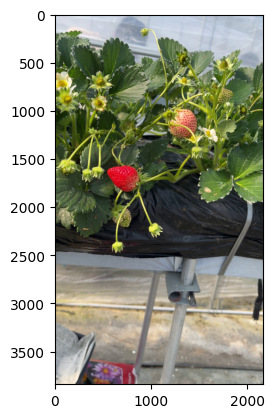

In [5]:
# 画像識別に使う画像を確認

iden_img_1_addr = '../datasets/identification/3_6_01501.png'
iden_img_1 = plt.imread(iden_img_1_addr)

plt.imshow(iden_img_1)
plt.show()

In [6]:
# モデルを使って画像識別

# result_1 = model(iden_img_1_addr, save=True)
model.predict(iden_img_1_addr, save=True, conf=0.7)


image 1/1 /home/kotameyan/Programing/labo/workspace/make_model/../datasets/identification/3_6_01501.png: 640x384 24 strawberrys, 57.7ms
Speed: 1.0ms preprocess, 57.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'strawberry'}
 orig_img: array([[[242, 232, 227],
         [244, 234, 229],
         [242, 232, 227],
         ...,
         [200, 180, 163],
         [200, 180, 163],
         [201, 181, 164]],
 
        [[244, 234, 229],
         [244, 234, 229],
         [244, 234, 229],
         ...,
         [200, 180, 163],
         [200, 180, 163],
         [202, 182, 165]],
 
        [[242, 232, 227],
         [242, 232, 227],
         [242, 232, 227],
         ...,
         [200, 180, 163],
         [201, 181, 164],
         [202, 182, 165]],
 
        ...,
 
        [[216, 224, 228],
         [215, 223, 227],
         [216, 224, 228],
         ...,
         [132, 137, 135],
         [130, 135, 133],
         [131, 136, 134]],
 
        [[216, 224, 228],
         [215, 223, 227],
         [216, 224, 228],
         ...,
        

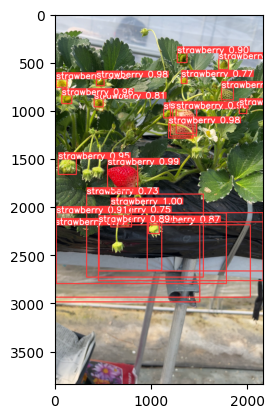

In [7]:
# 画像識別の結果を表示

guess_img_1_addr = './runs/detect/predict/3_6_01501.png'
guess_img_1 = plt.imread(guess_img_1_addr)

plt.imshow(guess_img_1)
plt.show()

画像識別（2）

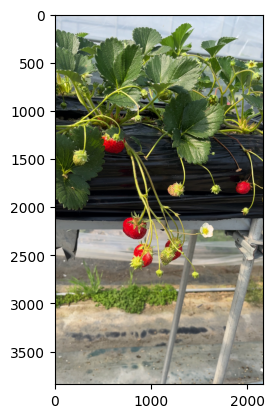

In [8]:
# 画像識別に使う画像を確認

iden_img_2_addr = '../datasets/identification/3_6_08881.png'
iden_img_2 = plt.imread(iden_img_2_addr)

plt.imshow(iden_img_2)
plt.show()

In [10]:
# モデルを使って画像識別

# result_2 = model(iden_img_2_addr, save=True)
model.predict(iden_img_2_addr, save=True, conf=0.7)


image 1/1 /home/kotameyan/Programing/labo/workspace/make_model/../datasets/identification/3_6_08881.png: 640x384 30 strawberrys, 20.2ms
Speed: 7.1ms preprocess, 20.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'strawberry'}
 orig_img: array([[[229, 217, 210],
         [229, 217, 210],
         [229, 217, 210],
         ...,
         [231, 216, 198],
         [231, 216, 198],
         [231, 216, 198]],
 
        [[229, 217, 210],
         [229, 217, 210],
         [228, 216, 209],
         ...,
         [229, 214, 196],
         [229, 214, 196],
         [229, 214, 196]],
 
        [[229, 217, 210],
         [229, 217, 210],
         [228, 216, 209],
         ...,
         [231, 217, 197],
         [231, 217, 197],
         [229, 215, 195]],
 
        ...,
 
        [[173, 181, 180],
         [173, 181, 180],
         [178, 186, 185],
         ...,
         [195, 184, 168],
         [194, 183, 167],
         [192, 181, 165]],
 
        [[174, 182, 181],
         [174, 182, 181],
         [179, 187, 186],
         ...,
        

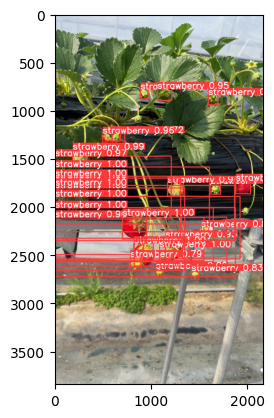

In [4]:
# 画像識別の結果を表示

guess_img_2_addr = './runs/detect/predict3/3_6_08881.png'
guess_img_2 = plt.imread(guess_img_2_addr)

plt.imshow(guess_img_2)
plt.show()